Now let's consider a MoE linear regression problem, and the loss function we want to minimize is

$$\min_{W, \theta_i} \mathbb{E}_{(x,y)\sim \mathcal P}\sum_{i\in [K]} (y-\mathbb{1}_{\{\text{argmax}(Wx)=i\}} (Wx)_i \cdot \theta_i x)^2$$

Note the multiplication of $(Wx)_i$ is to let gradient flow through $W$, such that the gating network gets updated.

In [223]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.nn.init as init
import torch
import torch.nn as nn

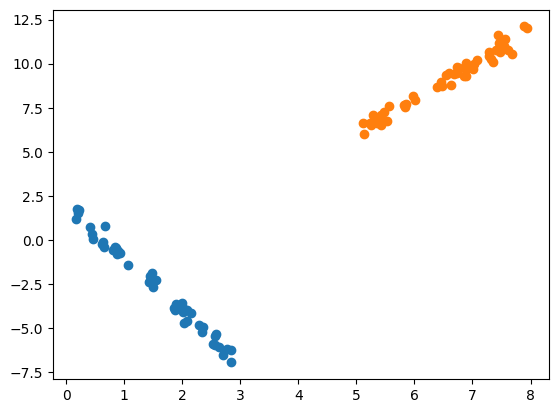

In [224]:
# data generatio 
n = 50
DATA_NUM = n*2
x1 = np.random.uniform(0,3, n)
x2 = np.random.uniform(5,8 ,n)
noise_std = 0.3
a1 = -3
b1 = 2
a2 = 2
b2 = -4
y1 = a1 * x1 + b1 + np.random.normal(0, noise_std, n)
y2 = a2 * x2 +b2 + np.random.normal(0, noise_std, n)
plt.scatter(x1,y1)
plt.scatter(x2,y2)
training_data = torch.hstack((torch.Tensor(x1), torch.Tensor(x2))).reshape((-1,1)).cuda()
training_labels = torch.hstack((torch.Tensor(y1), torch.Tensor(y2))).reshape(-1,1).cuda()

$\argmax (w_1 x+b_1, w_2 x+b_2)$

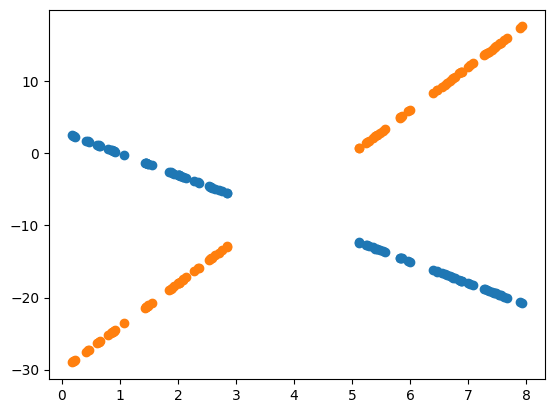

In [225]:
# start with a good initialization for router
#-3x+3
router_weight_init = torch.Tensor([[-3.0], [6.0]])
router_bias_init = torch.Tensor([3.0, -30])
plt.scatter(training_data.squeeze().cpu(),router_weight_init[0][0]*training_data.squeeze().cpu()+router_bias_init[0])
# 3x-26.5
plt.scatter(training_data.squeeze().cpu(),router_weight_init[1][0]*training_data.squeeze().cpu()+router_bias_init[1])

In [226]:

x1 = np.random.uniform(0,3, n)
x2 = np.random.uniform(5,8 ,n)
noise_std = 0.3
y1 = a1 * x1 + b1 + np.random.normal(0, noise_std, n)
y2 = a2 * x2 +b2 + np.random.normal(0, noise_std, n)
# plt.scatter(x1,y1)
# plt.scatter(x2,y2)
test_data = torch.hstack((torch.Tensor(x1), torch.Tensor(x2))).reshape((-1,1)).cuda()
test_labels = torch.hstack((torch.Tensor(y1), torch.Tensor(y2))).reshape((-1,1)).cuda()

In [227]:
import torch.nn as nn
import torch
class LinearRegressionModel(nn.Module):
    def __init__(self, inter_dim = 5):
        super(LinearRegressionModel, self).__init__()
        self.linear1 = nn.Linear(1, inter_dim, bias=True)
        self.linear2 = nn.Linear(inter_dim, 1, bias=False)  # One input feature, one output
        # self.reset_parameters()

    def forward(self, x):
        # ones_tensor = torch.ones(x.shape).cuda()
        # input = torch.hstack((x,ones_tensor))
        out = self.linear1(x)
        out = self.linear2(out)
        return out

    def reset_parameters(self):
        # self.linear.weight = torch.nn.Parameter(self.linear.weight * 0)
        nn.init.normal_(self.linear1.weight)
        nn.init.normal_(self.linear2.weight)
    
def gumbel_noise(n,k):
    unif = torch.distributions.Uniform(0,1).sample((n,k))
    g = -torch.log(-torch.log(unif))
    return g
    
class Router(nn.Module):
    def __init__(self, input_dim=1, out_dim =2, strategy='top1',noise=None, noise_type='gumbel'):
        super(Router, self).__init__()
        self.linear = nn.Linear(input_dim, out_dim)
        self.out_dim = out_dim
        self.strategy = strategy
        if self.strategy == 'top1':
            if noise is None:
                if noise_type == 'normal':
                    self.noise = torch.rand(DATA_NUM,out_dim).cuda()
                elif noise_type == "gumbel":
                    self.noise = gumbel_noise(DATA_NUM,out_dim).cuda()

            else:
                self.noise = noise
        # initialization
        self.reset_parameters()
        # init.constant_(self.linear.weight, [-3, 6])
        # init.constant_(self.linear.bias, [3, -26.5])
        # self.linear.weight.data = torch.Tensor([-3.0, 6.0])
        # self.linear.bias.data = torch.Tensor([3.0, -26.5])
        # init.normal_(self.linear.weight)
        # init.normal_(self.linear.bias)
    
    def reset_parameters(self):
        # self.linear.weight = torch.nn.Parameter(self.linear.weight * 0)
        self.linear.weight.data = torch.nn.Parameter(router_weight_init)
        self.linear.bias.data = torch.nn.Parameter(router_bias_init)
            
    def forward(self, x):      
        x = self.linear(x)
        if self.strategy == 'top1':
            output = x + self.noise
        else:
            output = x
        return output


In [228]:
lm = LinearRegressionModel()
x = torch.Tensor([1.0])
lm(x)

tensor([0.8066], grad_fn=<SqueezeBackward4>)

In [229]:
w = torch.matmul(lm.linear2.weight, lm.linear1.weight)
b = torch.matmul(lm.linear2.weight, lm.linear1.bias.reshape(-1,1))

In [230]:
w*x+b

tensor([[0.8066]], grad_fn=<AddBackward0>)

In [231]:
# one single linear regression model
# model = LinearRegressionModel().cuda()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# data = torch.Tensor(x1).reshape(-1,1).cuda()
# label = torch.Tensor(y1).reshape(-1,1).cuda()
# for epoch in range(500):
#     model.train()
#     optimizer.zero_grad()
#     y_pred = model(data)
#     loss = F.mse_loss(y_pred, label)
#     loss.backward()
#     optimizer.step()
#     print('epoch {}, loss {}'.format(epoch, loss.item()))

In [232]:
def top1(t):
    values, index = t.topk(k=1, dim=-1)
    values, index = map(lambda x: x.squeeze(dim=-1), (values, index))
    return values, index

class MoE(nn.Module):
    def __init__(self, input_dim, expert_num, strategy='top1', noise=None, noise_type='normal'):
        super(MoE, self).__init__()
        self.router = Router(input_dim, expert_num, strategy=strategy, noise=noise, noise_type = noise_type)
        self.models = nn.ModuleList()
        for i in range(expert_num):
            self.models.append(LinearRegressionModel())
        self.strategy = strategy
        self.expert_num = expert_num

    def forward(self, x):
        select = self.router(x)
        if self.strategy == 'top1':
            gate, index = top1(select)
        else:
            pass
        
        mask = F.one_hot(index, self.expert_num).float()
        # print("====> mask",index.size())
        density = mask.mean(dim=0)
        density_proxy = select.mean(dim=0)
        loss = (density_proxy * density).mean() * float(self.expert_num ** 2)

        mask_count = mask.sum(dim=0, keepdim=True)
        mask_flat = mask.sum(dim=1)

        combine_tensor =  (gate[..., None, None] * mask_flat[..., None, None]
                          * F.one_hot(index, self.expert_num)[..., None])
        # print("combine_tensor:",combine_tensor[0:10,:,:])

        # print(combine_tensor.size())
                          
        dispatch_tensor = combine_tensor.bool().to(combine_tensor) # denote expert assignment -- a tensor with 0/1 entries
        # print("dispatch_tensor:",dispatch_tensor[0:10,:,:])

        # print(dispatch_tensor.size())
        # print("dispatch_tensor:",dispatch_tensor)
        select0 = dispatch_tensor.squeeze(-1)
        
        x = x[...,None]
        expert_inputs = torch.einsum('bde,bne->nbe', x, dispatch_tensor)
        # print(expert_inputs)
        
        # x = torch.squeeze(x)
        output = []
        # print(expert_inputs[0].shape)
        for i in range(self.expert_num):
            self.models[i] = self.models[i].cuda()
            in_ = expert_inputs[i]
            output.append(self.models[i](in_))
        
        output = torch.stack(output)
        # output = (torch.einsum('ijk,jil->il', dispatch_tensor, output) - torch.einsum('ijk,jil->il', combine_tensor, output)).detach()\
        # + torch.einsum('ijk,jil->il', combine_tensor, output)
        output = torch.einsum('ijk,jil->il', combine_tensor, output) # combine gating weights with experts output

        # print('learnable scalar:', self.learnable_scalar.item())
        return output, select0, loss, gate, index, select

In [233]:
# select = torch.Tensor([[0.4,0.6],[0.2,0.8],[0.4,0.6],[0.3,0.7],[0.6,0.4]])
# mask = F.one_hot(torch.Tensor([1,1,1,1,0]).long(), 2).float()
# # print("====> mask",index.size())
# density = mask.mean(dim=0)
# density_proxy = select.mean(dim=0)
# loss = (density_proxy * density).mean() * float(2 ** 2)

In [234]:
# test
# x = torch.rand((5,1,1))
# index = torch.Tensor([0,1,1,0,0]).long()
# mask = F.one_hot(index, 2).float()
# gate = torch.Tensor([0.6,0.7,0.6,0.7,0.7])
# mask_flat = mask.sum(dim=1)

# combine_tensor =  (gate[..., None, None] * mask_flat[..., None, None]
#                           * F.one_hot(index, 2)[..., None])
# dispatch_tensor = combine_tensor.bool().to(combine_tensor)
# expert_inputs = torch.einsum('bde,bne->nbe', x, dispatch_tensor)
# output = []
# for i in range(2):
#     model = LinearRegressionModel().cuda()
#     in_ = expert_inputs[i].cuda()
#     output.append(model(in_))
# output1 = torch.stack(output).cpu()
# output2 = torch.einsum('ijk,jil->il', dispatch_tensor, output1)
# output = torch.einsum('ijk,jil->il', combine_tensor, output)
    

In [287]:
CLUSTER_NUM = 2
EXPERT_NUM = 2

def train(model, criterion, data, labels, optimizers, epochs, num_update_step_experts = 1, num_update_step_router = 2, plot=False, load_balancing=False, verbose=True):
    
    expert_acc_train = [[[] for x in range(CLUSTER_NUM)] for x in range(EXPERT_NUM)]
    expert_inner_train = [[[] for x in range(CLUSTER_NUM)] for x in range(EXPERT_NUM)]
    
    router_acc_train = [[] for x in range(CLUSTER_NUM)]
    router_inner_train = [[] for x in range(CLUSTER_NUM)]
    scheduler_router = lr_scheduler.StepLR(optimizers[1], step_size=300, gamma=0.2)
    scheduler_experts = lr_scheduler.StepLR(optimizers[0], step_size=200, gamma=0.5)
    # entropy_record = []
    gating_output = []
    index_ = []
    min_loss = 100
    router_grads = []
    loss_list = []
    select_list = []
    for epoch in range(epochs):  
        
        for optimizer in optimizers:
            optimizer.zero_grad()
        for step in range(max(num_update_step_experts, num_update_step_router)):
            if step < num_update_step_experts:
                optimizers[0].zero_grad()
                outputs, select0,  load_balancing_loss, gate, index, select = model(data)
                # gating_output.append(gate.detach().cpu())
                # index_.append(index.detach().cpu())
                loss = criterion(outputs, labels)
                loss.backward() 
                optimizers[0].step()
                # scheduler_experts.step()

            
            if step < num_update_step_router:
                optimizers[1].zero_grad()
                outputs, select0,  load_balancing_loss, gate, index, select = model(data)
                loss_ori = criterion(outputs, labels)
                if load_balancing:
                    loss = loss_ori + 0.1 * load_balancing_loss
                else:
                    loss = loss_ori
                loss.backward() 
                optimizers[1].step()
                scheduler_router.step()
                
        gating_output.append(gate.detach().cpu())
        index_.append(index.detach().cpu())
        
            
            # e = entropy(torch.stack([select0[train_cluster_idx[0]].squeeze(-1).sum(dim=0),
            #                          select0[train_cluster_idx[1]].squeeze(-1).sum(dim=0),
            #                          select0[train_cluster_idx[2]].squeeze(-1).sum(dim=0),
            #                          select0[train_cluster_idx[3]].squeeze(-1).sum(dim=0)]))
            # entropy_record.append(e)
            
            # if load_balancing:
            #     loss = criterion(outputs, labels) + 0.0001 * load_balancing_loss
            # else:
            #     loss = criterion(outputs, labels)


            # if loss.item() <= min_loss:
            #     min_loss = loss.item()
            # elif loss > min_loss+0.05 or loss <= 0.01:
            #     break
            # loss.backward() 

        loss_list.append(loss_ori.item())  
        select_list.append(select.detach().cpu())
        # for optimizer in optimizers:
        #     optimizer.step()

        router_grads.append(model.router.linear.weight.grad)
        # print('learnable param grad:',model.learnable_scalar.grad.detach())
        
        if epoch%50 == 0:
            if verbose:
                print('Epoch %d --- loss: %.3f' % (epoch + 1, loss_ori.item()))
            
    print('Finished Training')
    return select0, router_grads, gating_output, index_, loss_list, select_list


In [288]:
def test_single(model, criterion, data, labels):
    correct = 0
    
    with torch.no_grad():
        outputs,_,_,_,_,_ = model(data) # ,_
        predicted = outputs
        mse = criterion(predicted,labels)

    print('MSE of the network on the %d test images: %.4f ' % (data.shape[0], mse))
    
    return mse
    

def test(model, criterion, data, labels, verbose=True):
    correct = 0
    
    with torch.no_grad():
        outputs,_,_,_,_,_ = model(data) # ,_
        predicted = outputs
        mse = criterion(predicted,labels)

    if verbose:
        print('MSE of the network on the %d test images: %.4f '%  (data.shape[0],mse))
    
    return 100 * correct / data.shape[0]
    
    
def test_expert(model, criterion, data, labels, cluster=0, datatype='training', verbose=False):
    if datatype=='training':
        cluster_idx = train_cluster_idx
    else:
        cluster_idx = test_cluster_idx
        
    data = data[cluster_idx[cluster],:,:]
    labels = labels[cluster_idx[cluster]]
    expert_acc = []
    with torch.no_grad():
        for i in range(model.expert_num):
            predicted = model.models[i](data)
            mse = criterion(predicted, labels)
            # correct += (predicted == labels).sum().item()
            # acc = 100 * correct / data.shape[0]
            expert_acc.append(mse)
            if verbose:
                print('MSE of the %d expert on cluster %d with %d examples: %.4f' % (i, cluster, data.shape[0],
                                                                                             acc))
    return expert_acc
        
    
def test_each_expert(model, criterion, data, labels, datatype='training', verbose=False):
    expert_feature = [[] for x in range(EXPERT_NUM)]
    expert_center = [[] for x in range(EXPERT_NUM)]
    router_feature, router_center = test_router_inner(model)

    for i in range(CLUSTER_NUM):
        feat, cent = test_expert_inner(model, cluster=i)
        
        for each in range(EXPERT_NUM):
            expert_feature[each].append(feat[each].cpu())
            expert_center[each].append(cent[each].cpu())
            
    return expert_feature, expert_center, router_feature, router_center

def test_expert_inner(model, cluster=0):
    expert_fea = []
    expert_cen = []
    with torch.no_grad():
        for i in range(model.expert_num):
            feature_inner = torch.max(torch.abs(torch.matmul(model.models[i].conv1.weight.squeeze(1), 
                                         features[[cluster]].float().transpose(1,0))))
            center_inner = torch.max(torch.abs(torch.matmul(model.models[i].conv1.weight.squeeze(1), 
                                         centers[[cluster]].float().transpose(1,0))))
            expert_fea.append(feature_inner)
            expert_cen.append(center_inner)
    return expert_fea, expert_cen


def test_router_inner(model):
    router_feature = []
    router_center = []
    with torch.no_grad():
        for cluster in range(CLUSTER_NUM):
            ### torch.max
            feature_inner = torch.abs(torch.matmul(model.router.conv1.weight.squeeze(1), 
                                         features[[cluster]].float().transpose(1,0)))
            center_inner = torch.abs(torch.matmul(model.router.conv1.weight.squeeze(1), 
                                         centers[[cluster]].float().transpose(1,0)))
            router_feature.append(feature_inner.cpu().tolist())
            router_center.append(center_inner.cpu().tolist())
    return router_feature, router_center

In [289]:
from torch.optim.optimizer import Optimizer, required
from torch.optim import _functional

class NormalizedGD(Optimizer):
    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(NormalizedGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(NormalizedGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            d_p_list = []
            momentum_buffer_list = []
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
            lr = group['lr']

            for p in group['params']:
                if p.grad is not None:
                    # Normalizing 
                    if p.grad.norm() != 0:
                        p.grad /= p.grad.norm()
                        
                    params_with_grad.append(p)
                    d_p_list.append(p.grad)

                    state = self.state[p]
                    if 'momentum_buffer' not in state:
                        momentum_buffer_list.append(None)
                    else:
                        momentum_buffer_list.append(state['momentum_buffer'])

            _functional.sgd(params_with_grad,
                  d_p_list,
                  momentum_buffer_list,
                  weight_decay=weight_decay,
                  momentum=momentum,
                  lr=lr,
                  dampening=dampening,
                  nesterov=nesterov,
                  maximize=False)

            # update momentum_buffers in state
            for p, momentum_buffer in zip(params_with_grad, momentum_buffer_list):
                state = self.state[p]
                state['momentum_buffer'] = momentum_buffer

        return loss

In [290]:
data = []
labels = []
train_cluster_idx = [[] for x in range(CLUSTER_NUM)]
test_cluster_idx = [[] for x in range(CLUSTER_NUM)]

for i in range(n*2):
    k = np.random.choice(list(range(0,CLUSTER_NUM)))
    
    if i < n:
        train_cluster_idx[k].append(i)
    else:
        test_cluster_idx[k].append(i-n)


In [315]:
from torch.optim import lr_scheduler
num_epochs = 800
moe = MoE(1, 2,strategy='top1', noise=None, noise_type='normal').cuda() #input_dim, out_channel (m), cluter_num, patch_num

criterion = torch.nn.MSELoss()
optimizer = NormalizedGD(moe.models.parameters(), lr=1e-2)
optimizer2 = torch.optim.Adam(moe.router.parameters(), lr=0.1) #top1 lr 0.1

#select0, router_grads, gating_output, index_, loss_list
select0, router_grads, gating_outputs, index_, loss_list , select = train(moe, criterion, training_data, training_labels, 
                                                           [optimizer,optimizer2], num_epochs, 
                                                           num_update_step_experts=2, 
                                                           num_update_step_router=1, plot=False, load_balancing=True)
print(select0.squeeze(-1).sum(dim=0))

test(moe, criterion, training_data, training_labels)
test(moe, criterion, test_data, test_labels)

# print(select[train_cluster_idx[0]].squeeze(-1).sum(dim=0).to(torch.long))
# print(select[train_cluster_idx[1]].squeeze(-1).sum(dim=0).to(torch.long))

Epoch 1 --- loss: 112.889
Epoch 51 --- loss: 5.799
Epoch 101 --- loss: 5.207
Epoch 151 --- loss: 3.111
Epoch 201 --- loss: 2.639
Epoch 251 --- loss: 3.212
Epoch 301 --- loss: 3.305
Epoch 351 --- loss: 3.172
Epoch 401 --- loss: 3.360
Epoch 451 --- loss: 3.731
Epoch 501 --- loss: 3.866
Epoch 551 --- loss: 4.006
Epoch 601 --- loss: 4.126
Epoch 651 --- loss: 4.127
Epoch 701 --- loss: 4.131
Epoch 751 --- loss: 4.135
Finished Training
tensor([11., 89.], device='cuda:0')
MSE of the network on the 100 test images: 4.2340 
MSE of the network on the 100 test images: 4.6500 


0.0

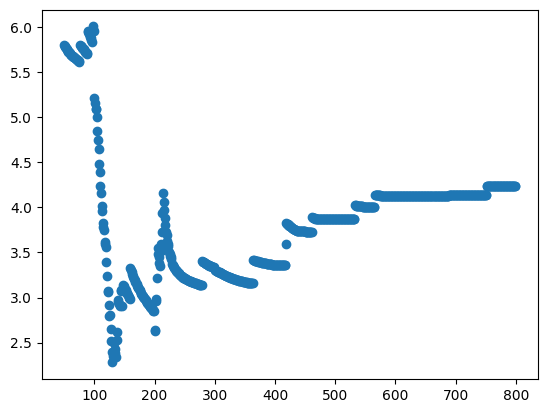

In [316]:
i = 50
plt.scatter(np.arange(len(loss_list))[i:], loss_list[i:])

In [317]:
gating_outputs_x1 = torch.vstack([moe.router.linear.weight[0]*torch.Tensor(x1).cuda()+moe.router.linear.bias[0],
              moe.router.linear.weight[1]*torch.Tensor(x1).cuda()+moe.router.linear.bias[1]])
x1_assignments = torch.argmax(gating_outputs_x1, dim=0)
gating_outputs_x2 = torch.vstack([moe.router.linear.weight[0]*torch.Tensor(x2).cuda()+moe.router.linear.bias[0],
              moe.router.linear.weight[1]*torch.Tensor(x2).cuda()+moe.router.linear.bias[1]])
x2_assignments = torch.argmax(gating_outputs_x2, dim=0)

In [318]:
print(x1_assignments)
print(x2_assignments)

tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1], device='cuda:0')


In [319]:
ei_x1 = gating_outputs_x1[x1_assignments,:][0,:].detach().cpu().numpy()
ei_x2 = gating_outputs_x2[x2_assignments,:][0,:].detach().cpu().numpy()

In [320]:
w1 = torch.matmul(moe.models[0].linear2.weight, moe.models[0].linear1.weight)[0].item()
b1 = torch.matmul(moe.models[0].linear2.weight, moe.models[0].linear1.bias.reshape(-1,1))[0].item()
w2 = torch.matmul(moe.models[1].linear2.weight, moe.models[1].linear1.weight)[0][0].item()
b2 = torch.matmul(moe.models[1].linear2.weight, moe.models[1].linear1.bias.reshape(-1,1))[0].item()
print(w1)
print(b1)
print(w2)
print(b2)

0.31695613265037537
-0.19882646203041077
0.05686625838279724
0.12480196356773376


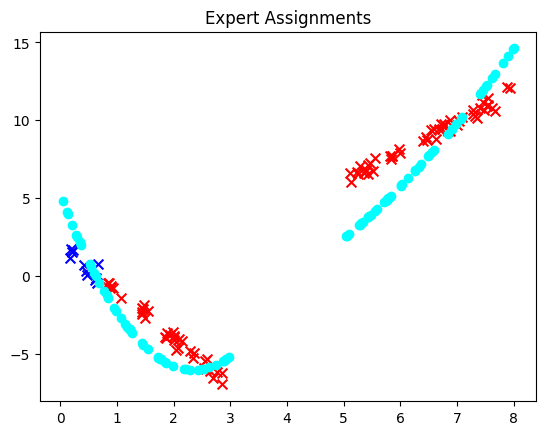

In [321]:
expert_1 = (select0[:,0] == 1).cpu()
expert_2 = (select0[:,1] == 1).cpu()

expert_1_idx = torch.arange(DATA_NUM).long()[expert_1]
expert_2_idx = torch.arange(DATA_NUM).long()[expert_2]

plt.scatter(training_data.cpu()[expert_1_idx,0],training_labels.cpu()[expert_1_idx,0], s=50, marker='x',color='blue')
plt.scatter(training_data.cpu()[expert_2_idx,0],training_labels.cpu()[expert_2_idx,0], s=50, marker='x',color='red')
plt.title('Expert Assignments')
plt.scatter(x1, (w1*x1+b1)*ei_x1,color='cyan')
plt.scatter(x2, (w2*x2+b2)*ei_x2,color='cyan')
# plt.scatter(visual_data[np.array(expert_2_idx)[training_labels.cpu()[expert_2] == 0],0],visual_data[np.array(expert_2_idx)[training_labels.cpu()[expert_2] == 0],1], s=50, marker='x',color='#fdae61')
# plt.scatter(visual_data[np.array(expert_2_idx)[training_labels.cpu()[expert_2] == 1],0],visual_data[np.array(expert_2_idx)[training_labels.cpu()[expert_2] == 1],1], s=50, marker='o',color='#fdae61')


Text(50.722222222222214, 0.5, '#epochs')

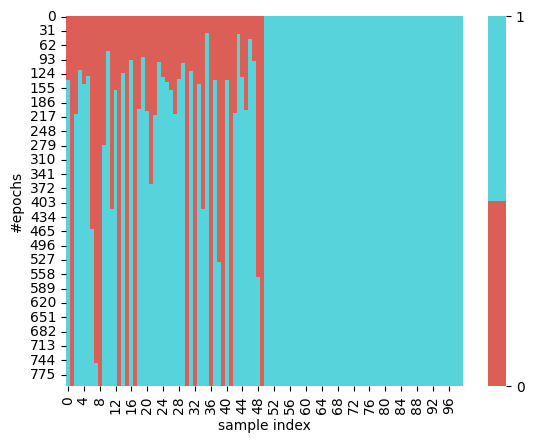

In [322]:
# now let us visualize each data point's expert assignment in each training epoch
import seaborn as sns
index__ = torch.stack(index_ )
ax = sns.heatmap(index__,cmap=sns.color_palette("hls",n_colors=2))
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0,1])
colorbar.set_ticklabels([0,1])
ax.set_xlabel('sample index')
ax.set_ylabel('#epochs')

<Axes: >

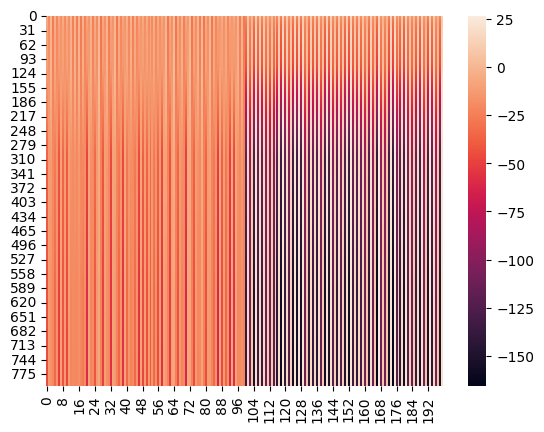

In [323]:
sns.heatmap(torch.stack(select).view(-1,200))

In [324]:
torch.stack(router_grads).size()

torch.Size([800, 2, 1])

tensor([ -0.0420, -23.2885])
tensor([-0.1254,  3.0298])
tensor([ 0.1357, -0.0780])


<Axes: >

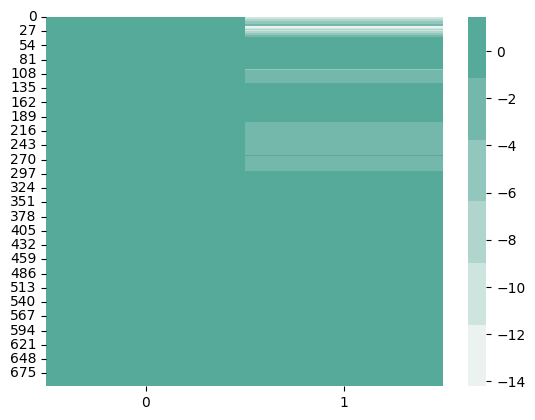

In [325]:
# Set up a 1x3 grid for subplots
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first heatmap
print(torch.squeeze(router_grads[9]).cpu())
# axes[0].set_title('Grad heatmap 9')

# Plot the second heatmap
print(torch.squeeze(router_grads[49]).cpu())
# axes[1].set_title('Grad heatmap 49')

# Plot the third heatmap
print(torch.squeeze(router_grads[409]).cpu())
# sns.heatmap(torch.squeeze(router_grads[409]).cpu(),  fmt="d",  ax=axes[2])
# axes[2].set_title('Grad heatmap 409')

# Adjust layout and show the plot
# plt.tight_layout()
# plt.show()

sns.heatmap(torch.squeeze(torch.stack(router_grads))[100:,:].cpu(),  cbar=True, cmap = sns.color_palette("light:#5A9"), fmt="d")



Text(50.722222222222214, 0.5, '#epochs')

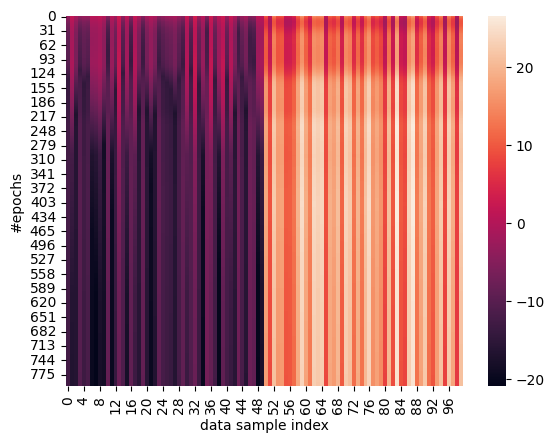

In [326]:
# visualize the top 1 gating output
import seaborn as sns
gating_outputs_tensor = torch.stack(gating_outputs)
ax = sns.heatmap(gating_outputs_tensor[:,0:100])
ax.set_xlabel('data sample index')
ax.set_ylabel('#epochs')